In [261]:
import numpy as np
import pandas as pd
from sklearn import datasets

random_state = 12

In [262]:
dataset = datasets.load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset['feature_names'])
y = dataset.target

In [280]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=random_state, train_size=0.8)

In [281]:
import pandas as pd
from sklearn.neighbors import BallTree
from sklearn.metrics import f1_score
from scipy import stats as st


class KNNClassifier:
    bt: BallTree = None
    ys: np.ndarray = None
    weights: np.ndarray = None
    kernels = {
        'uniform': lambda x: st.uniform.pdf(x, loc=-1, scale=2),
        'gaussian': st.norm.pdf,
        'triangular': lambda x: st.triang.pdf(x, c=0.5, loc=-1, scale=2),
        'epanechnikov': lambda x: 3 / 4 * (1 - x ** 2) * (x < 1)
    }
    metrics = set(BallTree.valid_metrics)

    def __init__(self, window: float | None = None, metric: str = 'euclidean', kernel: str = 'gaussian',
                 k: int = 1, window_type: str = 'non_fixed', leaf_size: int = 30, lowess_iterations: int = 1):
        assert metric in self.metrics
        assert kernel in self.kernels

        self.k = k
        self.lowess_iterations = lowess_iterations
        self.window = None if window_type != 'fixed' else window
        self.n_classes = None
        self.metric = metric
        self.kernel = self.kernels[kernel]
        self.leaf_size = leaf_size

    def fit(self, x: pd.DataFrame, y: np.ndarray):
        x = x.reset_index(drop=True)
        self.ys = y
        self.n_classes = len(np.unique(y))
        self.weights = np.array([1.0] * len(y))
        for i in range(self.lowess_iterations):
            for j in range(len(y)):
                self.bt = BallTree(x.drop(j), self.leaf_size, metric=self.metric)
                pred = self.predict(x.iloc[j:j + 1])[0]
                self.weights[j] = st.norm.pdf(y[j] - pred)

        self.bt = BallTree(x, self.leaf_size, metric=self.metric)
        return self

    def predict(self, x: pd.DataFrame) -> np.ndarray:
        distances, neighbours = self.bt.query(x, self.k + 1 if self.window is None else self.k)
        if self.window is None:
            neighbours = np.delete(neighbours, self.k, 1)
        neighbours = pd.DataFrame(neighbours)
        weights = neighbours.applymap(lambda x: self.weights[x]).to_numpy()
        distances: np.ndarray = distances
        h = self.window if self.window is not None else distances.T[-1][:, None]
        distances /= h
        distances = self.kernel(distances)
        ys = neighbours.applymap(lambda x: self.ys[x]).astype(int).T
        if self.window is None:
            distances = np.delete(distances, self.k, 1)

        distances *= weights
        answers = np.array([0] * len(x))
        s: np.ndarray = np.array([0.0] * self.n_classes)
        for i in range(len(x)):
            s.fill(0)
            for j, dist in enumerate(distances[i]):
                s[ys[i][j]] += dist
            answers[i] = np.argmax(s)

        return answers

    def score(self, x: pd.DataFrame, y: np.ndarray) -> np.float32:
        return f1_score(y, self.predict(x))


In [282]:
knn = KNNClassifier(window=10000.0, metric='euclidean', kernel='epanechnikov', k=5)

In [283]:
knn = knn.fit(X_train, y_train)

In [284]:
knn.score(X_test, y_test)

0.920863309352518

In [285]:
import optuna


def optimize(trial):
    window_type = trial.suggest_categorical('window_type', ['fixed', 'non_fixed'])
    window = None if window_type != 'fixed' else trial.suggest_float('window', 0, 200000, step=1000)
    metric = trial.suggest_categorical('metric', ['euclidean', 'minkowski', 'chebyshev', 'l1'])
    kernel = trial.suggest_categorical('kernel', KNNClassifier.kernels.keys())
    k = trial.suggest_int('k', 1, 15)
    leaf_size = trial.suggest_int('leaf_size', 10, 60)
    lowess_iterations = trial.suggest_int('lowess_iterations', 0, 1)

    knn = KNNClassifier(window=window, metric=metric, kernel=kernel, k=k, window_type=window_type, leaf_size=leaf_size,
                        lowess_iterations=lowess_iterations).fit(X_train, y_train)
    return knn.score(X_val, y_val)

In [286]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(optimize, n_trials=100)

[I 2024-03-12 15:46:43,436] A new study created in memory with name: no-name-7bc37e46-bdb6-47c7-b832-74830c0b3839
[I 2024-03-12 15:46:44,204] Trial 0 finished with value: 0.9814814814814815 and parameters: {'window_type': 'non_fixed', 'metric': 'l1', 'kernel': 'triangular', 'k': 5, 'leaf_size': 40, 'lowess_iterations': 1}. Best is trial 0 with value: 0.9814814814814815.
[I 2024-03-12 15:46:44,210] Trial 1 finished with value: 0.9622641509433962 and parameters: {'window_type': 'fixed', 'window': 104000.0, 'metric': 'chebyshev', 'kernel': 'uniform', 'k': 5, 'leaf_size': 44, 'lowess_iterations': 0}. Best is trial 0 with value: 0.9814814814814815.
[I 2024-03-12 15:46:44,218] Trial 2 finished with value: 0.9719626168224299 and parameters: {'window_type': 'fixed', 'window': 147000.0, 'metric': 'l1', 'kernel': 'gaussian', 'k': 7, 'leaf_size': 33, 'lowess_iterations': 0}. Best is trial 0 with value: 0.9814814814814815.
[I 2024-03-12 15:46:44,226] Trial 3 finished with value: 0.9719626168224299

In [287]:
study.best_value, study.best_params

(0.9814814814814815,
 {'window_type': 'non_fixed',
  'metric': 'l1',
  'kernel': 'triangular',
  'k': 5,
  'leaf_size': 40,
  'lowess_iterations': 1})

In [288]:
knn = KNNClassifier(**study.best_params).fit(X_train, y_train)
knn.score(X_test, y_test)

0.935251798561151

In [289]:
from sklearn.neighbors import KNeighborsClassifier


def optimize_baseline(trial):
    metric = trial.suggest_categorical('metric', ['euclidean', 'minkowski', 'chebyshev', 'l1'])
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute', 'auto'])
    leaf_size = trial.suggest_int('leaf_size', 10, 60)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size,
                               metric=metric).fit(X_train, y_train)
    return knn.score(X_val, y_val)

In [290]:
baseline_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
baseline_study.optimize(optimize_baseline, n_trials=100)

[I 2024-03-12 15:48:32,624] A new study created in memory with name: no-name-865a5cee-86c9-4791-99e0-07420d7f5905
[I 2024-03-12 15:48:32,632] Trial 0 finished with value: 0.9340659340659341 and parameters: {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 40}. Best is trial 0 with value: 0.9340659340659341.
[I 2024-03-12 15:48:32,635] Trial 1 finished with value: 0.967032967032967 and parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 1 with value: 0.967032967032967.
[I 2024-03-12 15:48:32,643] Trial 2 finished with value: 0.967032967032967 and parameters: {'metric': 'l1', 'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 1 with value: 0.967032967032967.
[I 2024-03-12 15:48:32,649] Trial 3 finished with value: 0.9560439560439561 and parameters: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform', 'alg

In [291]:
baseline_study.best_value, baseline_study.best_params

(0.967032967032967,
 {'metric': 'euclidean',
  'n_neighbors': 9,
  'weights': 'distance',
  'algorithm': 'kd_tree',
  'leaf_size': 15})

In [292]:
baseline = KNeighborsClassifier(**baseline_study.best_params).fit(X_train, y_train)
baseline.score(X_test, y_test)

0.9122807017543859

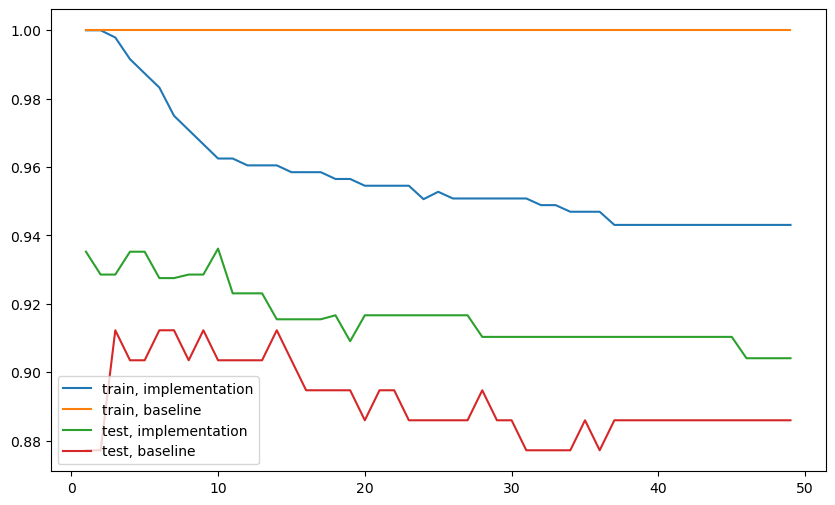

In [293]:
import matplotlib.pyplot as plt


def plot(k: int, X, y):
    params = study.best_params
    params['k'] = k
    knn = KNNClassifier(**params).fit(X_train, y_train)
    return knn.score(X, y)


def plot_baseline(k: int, X, y):
    params = baseline_study.best_params
    params['n_neighbors'] = k
    baseline = KNeighborsClassifier(**params).fit(X_train, y_train)
    return baseline.score(X, y)


ks = list(range(1, 50))
plt.figure(figsize=(10, 6))
plt.plot(ks, [plot(k, X_train, y_train) for k in ks], label='train, implementation')
plt.plot(ks, [plot_baseline(k, X_train, y_train) for k in ks], label='train, baseline')
plt.plot(ks, [plot(k, X_test, y_test) for k in ks], label='test, implementation')
plt.plot(ks, [plot_baseline(k, X_test, y_test) for k in ks], label='test, baseline')
plt.legend();